## 前言  

> 股價預測主要是希望藉由過去的股價記錄預測未來的股價，在統計上，通常會使用簡單迴歸，乃至複雜的時間序列分析(Time Series Analysis)來預測股價趨勢，因為，當期的股價通常會與前期有緊密的關係，除非公司或大環境發生重大事件，否則，應該會循著規律變化。  
> 本文使用 Kaggle 上之 TESLA 股價資料，內含2010-2020年 TESLA 股價數據，本次分析欲瞭解：1. 2010~2020，十年間 TESLA 股價變化趨勢 2.預測未來股價。

資料集來源 : https://www.kaggle.com/datasets/timoboz/tesla-stock-data-from-2010-to-2020

## [ 資料前處理 ]  
### 導入工具包 / 資料集

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('TESLA.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


In [3]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
2411,2020-01-28,568.489990,576.809998,558.080017,566.900024,566.900024,11788500
2412,2020-01-29,575.690002,589.799988,567.429993,580.989990,580.989990,17801500
2413,2020-01-30,632.419983,650.880005,618.000000,640.809998,640.809998,29005700
2414,2020-01-31,640.000000,653.000000,632.520020,650.570007,650.570007,15719300
2415,2020-02-03,673.690002,786.140015,673.520020,780.000000,780.000000,47065000


### 資料觀察

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2416 entries, 0 to 2415
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2416 non-null   object 
 1   Open       2416 non-null   float64
 2   High       2416 non-null   float64
 3   Low        2416 non-null   float64
 4   Close      2416 non-null   float64
 5   Adj Close  2416 non-null   float64
 6   Volume     2416 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 132.2+ KB


從`info()`，可看到此資料集中含有7欄，2416筆商品資料，欄位中沒有空值，各欄位資訊如下： 
- Date 股票日期
- Open 開盤價  
- High 最高價  
- Low 最低價 
- Close 收盤價  
- Volume 成交量  
- Adj Close 調整後收盤價  

### 檢查資料是否有異常


In [5]:
df.nunique() #無異常

Date         2416
Open         2132
High         2128
Low          2136
Close        2225
Adj Close    2225
Volume       2391
dtype: int64

股票類型資料，日期是其唯一值，由`nunique()`欄位可以確定資料集中的「Date」欄沒有重複

### 資料清洗

In [6]:
# 日期轉換
df['Date'] = pd.to_datetime(df['Date'])

股票資料讀入Python時，日期欄常會跑掉，故將其作轉換

In [7]:
# 空值處理
print('nan value in each columns:')
print(df.isnull().sum())

nan value in each columns:
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


由上可知此資料集內沒有NA值，無需做空值處理

**⇣ 著重在股價預測，故針對「Close」(收盤價) 此欄做離群值觀察**

<AxesSubplot: >

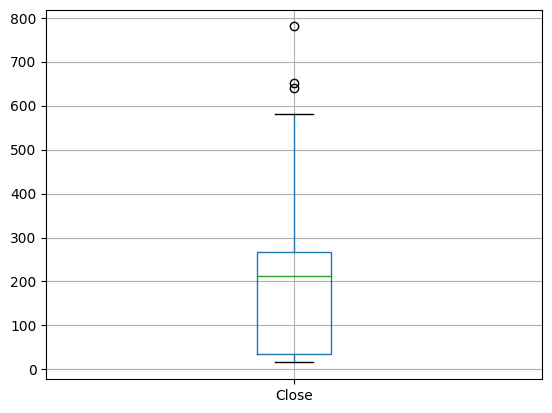

In [8]:
# "Close"離群值
df.boxplot('Close')

從盒狀圖可以看到此資料集僅有少數離群值

In [9]:
df['Close'].describe()  ## 應變量 y 觀察 

count    2416.000000
mean      186.403651
std       119.136020
min        15.800000
25%        34.400002
50%       212.960007
75%       266.774994
max       780.000000
Name: Close, dtype: float64

### 鎖定分析方向
> 本次分析欲瞭解：1. 2010~2020，十年間 TESLA 股價變化趨勢 2.預測未來股價

In [10]:
# 定義昨日及前日收盤價
df['Yes Close'] = df['Close'].shift(1)
df['Dby Close'] = df['Yes Close'].shift(1)

df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Yes Close,Dby Close
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300,NaN,NaN
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100,23.889999,NaN
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800,23.830000,23.889999
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800,21.959999,23.830000
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900,19.200001,21.959999


**⇣ 從上表可看到前兩筆資料有缺失值，需做處理**

In [11]:
df = df.dropna().reset_index()
df = df.iloc[:,1:]
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Yes Close,Dby Close
0,2010-07-01,25.000000,25.920000,20.270000,21.959999,21.959999,8218800,23.830000,23.889999
1,2010-07-02,23.000000,23.100000,18.709999,19.200001,19.200001,5139800,21.959999,23.830000
2,2010-07-06,20.000000,20.000000,15.830000,16.110001,16.110001,6866900,19.200001,21.959999
3,2010-07-07,16.400000,16.629999,14.980000,15.800000,15.800000,6921700,16.110001,19.200001
4,2010-07-08,16.139999,17.520000,15.570000,17.459999,17.459999,7711400,15.800000,16.110001


In [12]:
data = df.copy()

**⇣ 2010~2020，十年間 TESLA 股價變化及成交量趨勢**

In [13]:
# 將"Date"轉為index
data.index = data['Date']
data.drop('Date', axis = 1, inplace = True)   # 資料集原含有Date欄，故刪除此欄資料
data.head()

,Open,High,Low,Close,Adj Close,Volume,Yes Close,Dby Close
Date,,,,,,,,
2010-07-01,25.000000,25.920000,20.270000,21.959999,21.959999,8218800,23.830000,23.889999
2010-07-02,23.000000,23.100000,18.709999,19.200001,19.200001,5139800,21.959999,23.830000
2010-07-06,20.000000,20.000000,15.830000,16.110001,16.110001,6866900,19.200001,21.959999
2010-07-07,16.400000,16.629999,14.980000,15.800000,15.800000,6921700,16.110001,19.200001
2010-07-08,16.139999,17.520000,15.570000,17.459999,17.459999,7711400,15.800000,16.110001


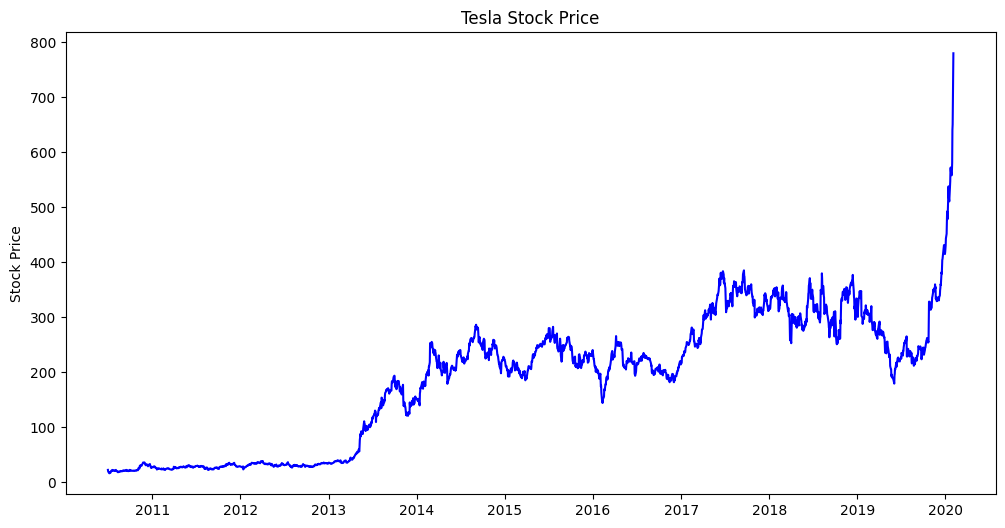

In [14]:
# 2010 - 2020股價變化趨勢
plt.figure(figsize = (12, 6))
plt.plot(data['Close'], color = 'blue')
plt.ylabel('Stock Price')
plt.xlabel(None)
plt.title('Tesla Stock Price')
plt.show()

由股價變化趨勢圖可以看到，在2011-2013年時，股價約都維持在每股50美元左右，直至2013年末突破每股100美元後，2014-2019年，每股也持續維持在100-400美元間，而於2020年每股飆升至600-800美元。

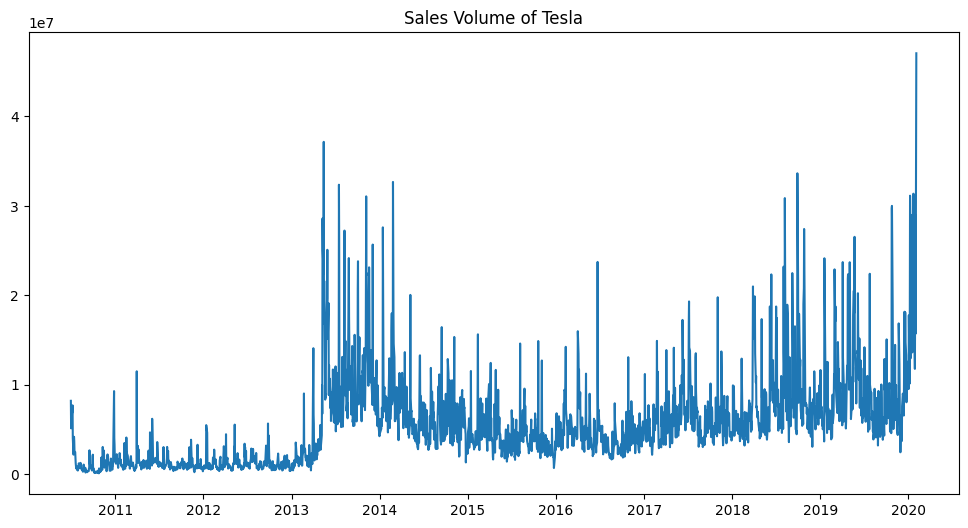

In [15]:
# 2010 - 2020成交量趨勢
plt.figure(figsize = (12, 6))
plt.plot(data['Volume'])
plt.ylabel(None)
plt.xlabel(None)
plt.title('Sales Volume of Tesla')
plt.show()

**⇣ 針對'Close'欄位畫分佈圖，觀察收盤價分佈情形**

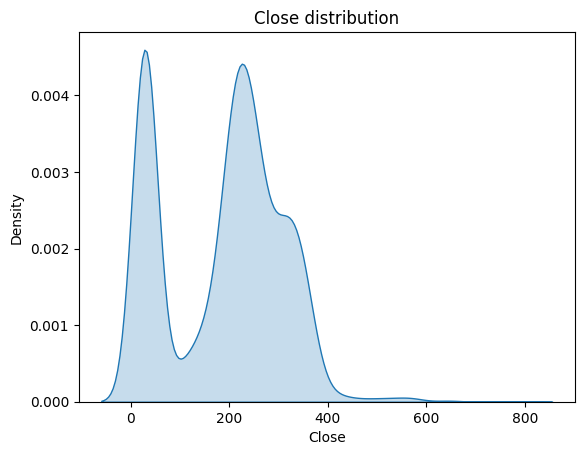

In [16]:
# 收盤價分怖
ax = plt.axes()
sns.kdeplot(df['Close'], fill = 'fill', ax = ax)
ax.set_title('Close distribution')
plt.show()

由收盤價分佈圖，可看到「Close」欄位價格高、低，各別佔一大部分，呈現M型化。

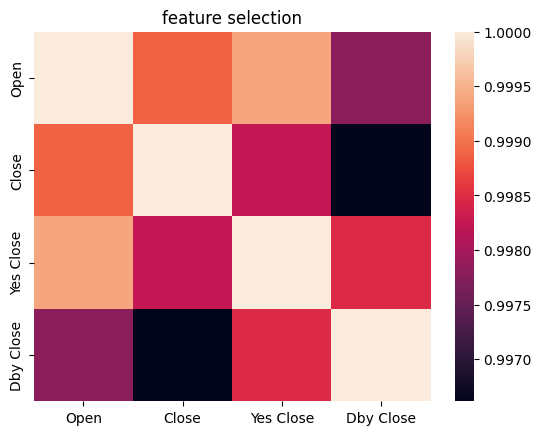

In [17]:
# 相關性 :開盤價、收盤價、昨日收盤價、前日收盤價
cor_df = df[['Open', 'Close', 'Yes Close', 'Dby Close']]
cor = cor_df.corr()
ax = plt.axes()
sns.heatmap(cor, ax = ax)
ax.set_title('feature selection')
plt.show()

### 初步結論
透過2010 - 2020，十年間的特斯拉股票，得出以下分析結論:
1. 2013年中後特斯拉股價突破100美元且持續成長，於2020年每股飆升至600-800美元
2. 收盤價與開盤價、昨天收盤價有極強的關係

接著繼續針對未來股價進行預測

## [ 開始預測 ]

In [18]:
# 導入工具包
from sklearn import preprocessing, svm, ensemble
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

In [19]:
# 設定特徵向量X及對應的標籤y
y = cor_df['Close']
X = cor_df.drop(['Close'], axis = 1)
print(X.shape)
print(y.shape)

(2414, 3)
(2414,)


In [20]:
# 將資料分成訓練資料及測試資料
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.2, random_state = 1)
y_test = y_test.reset_index()

# 標準化訓練資料及測試資料
scaler = preprocessing.MinMaxScaler(feature_range=(0,1)).fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### SVM - 預測

In [21]:
# 定義SVM模型並訓練
svm_model = svm.SVR(kernel = 'rbf')
svm_model.fit(X_train,y_train)

svm_model_pred = svm_model.predict(X_test)
svm_model_pred = pd.DataFrame(svm_model_pred).reset_index()

# 驗證結果 - MAPE
np.mean(np.abs((y_test['Close'] - svm_model_pred[0]) / y_test['Close'])) * 100

5.799979740228475

### 隨機森林 - 預測

In [22]:
# 定義RandomForest模型並訓練
forest_model = ensemble.RandomForestRegressor(n_estimators = 100)
forest_model.fit(X_train,y_train)

forest_model_pred = forest_model.predict(X_test)
forest_model_pred = pd.DataFrame(forest_model_pred).reset_index()

# 驗證結果 - MAPE
np.mean(np.abs((y_test['Close'] - forest_model_pred[0]) / y_test['Close'])) * 100

2.156667605754795

### XGB - 預測

In [23]:
# 定義xgboost模型並訓練
xgb_model = XGBRegressor(n_estimators = 100, learning_rate = 0.3)
xgb_model.fit(X_train,y_train)

xgb_model_pred = xgb_model.predict(X_test)
xgb_model_pred = pd.DataFrame(xgb_model_pred).reset_index()

# 驗證結果 - MAPE
np.mean(np.abs((y_test['Close'] - xgb_model_pred[0]) / y_test['Close'])) * 100

2.272552267938445

### 結論
上面3個模型，若由 MAPE（平均絕對百分比誤差）評估，可以發現，在預測股價中，隨機森林模型及XGBoosting模型表現得比較好一點；而SVM模型則表顯得較不理想。

**⇣ RandomForest模型準確度較高，因此用其預測新資料**

In [24]:
import warnings
warnings.filterwarnings("ignore")

# 餵新資料預測
new = {'Open':[601], 'Yes Close':[602.5], 'Dby Close':[604.7]}
new = pd.DataFrame(new)
print(new)
print('==========')

new_predict = forest_model.predict(new)
print(f'股價預測：{new_predict}')

   Open  Yes Close  Dby Close
0   601      602.5      604.7
股價預測：[612.94810264]
